In [112]:
# based on the results of jupyternotebooks/explore-data.ipynb, we will try to actually 
# make predictions in time
# background: an eth trade takes 15-30 secs on average...
import pandas as pd

df = pd.read_parquet("../data/ETHTUSD.parquet.gzip")
df = df.drop(["month", "year", "symbol"], axis = 1)
print(df.shape)
df.head()

(53000, 11)


,min,max,mean,median,quantity_count,quantity_sum,quantity_min,quantity_max,quantity_mean,quantity_median,side
timestamp,,,,,,,,,,,
2024-01-27 10:35:46.433085+00:00,2294.52,2303.20,2298.2651,2297.965,100,108.0758,0.0022,56.4191,1.080758,0.0398,asks
2024-01-27 10:35:46.780221+00:00,2294.52,2303.20,2298.2651,2297.965,100,108.0758,0.0022,56.4191,1.080758,0.0398,asks
2024-01-27 10:35:47.121114+00:00,2294.52,2303.33,2298.4287,2298.095,100,107.9737,0.0022,56.4191,1.079737,0.0260,asks
2024-01-27 10:35:47.902214+00:00,2294.52,2303.33,2298.4287,2298.095,100,107.9737,0.0022,56.4191,1.079737,0.0260,asks
2024-01-27 10:35:48.254500+00:00,2294.52,2303.33,2298.4287,2298.095,100,107.9737,0.0022,56.4191,1.079737,0.0260,asks


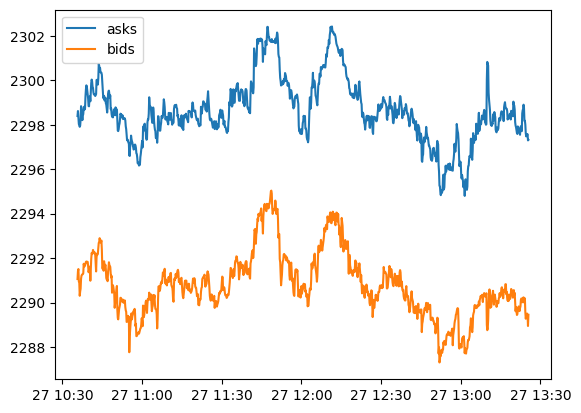

In [113]:
asks = df[df["side"] == "asks"].drop("side", axis = 1)
bids = df[df["side"] == "bids"].drop("side", axis = 1)
# resample into 10 second intervals
asks = asks.resample("10S").mean()
bids = bids.resample("10S").mean()

import matplotlib.pyplot as plt
plt.plot(asks["mean"], label = "asks")
plt.plot(bids["mean"], label = "bids")
plt.legend()


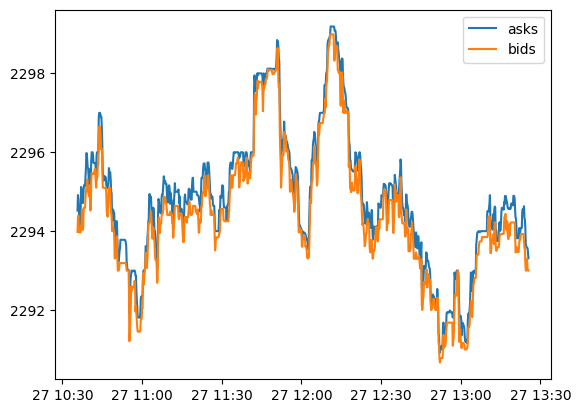

In [114]:
plt.plot(asks["min"], label = "asks")
plt.plot(bids["max"], label = "bids")
plt.legend()

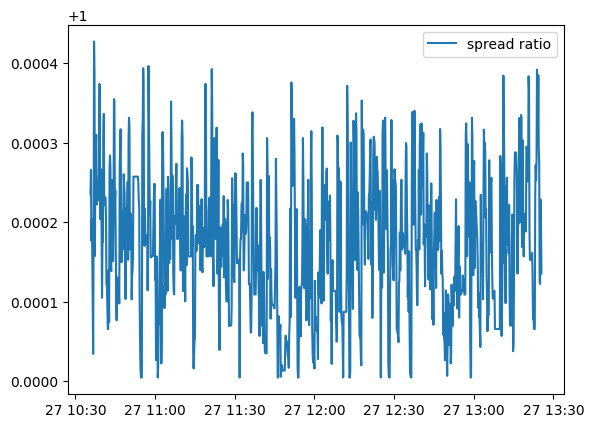

In [115]:
plt.plot(asks["min"] / bids["max"], label = "spread ratio")
plt.legend()

In [116]:
# add features
from ta import add_all_ta_features
def featureExtension(df):
    df["spread"] = df["max"] / df["min"]
    df["vol_diff_mean_median"] = df["quantity_mean"] / df["quantity_median"]
    df["vol_spread"] = df["quantity_max"] / df["quantity_min"]
    df["mean_pct_change"] = df["mean"].pct_change()
    df["signal"] = df["mean_pct_change"].apply(lambda x: 1 if x > 0 else 0)
    # for the target, we will try to predict the price in 60 seconds, basically when our trade would make it through
    df["target"] = df["mean"].pct_change(6).ffill().fillna(0).apply(lambda x: 1 if x > 0 else 0)
    # technical stats
    priceStats = add_all_ta_features(df, open="mean", high="max", low="min", close="mean", volume="quantity_sum", fillna=True)
    volumeStats = add_all_ta_features(df, open="quantity_mean", high="quantity_max", low="quantity_min", close="quantity_mean", volume="quantity_sum", fillna=True)
    # merge them all back together, but with prefixes
    df = df.join(priceStats.add_prefix("price_"))
    df = df.join(volumeStats.add_prefix("volume_"))
    return df

asks = featureExtension(asks)
bids = featureExtension(bids)
# and then unite them again with prefix bid_ and ask_
df = pd.concat([asks.add_prefix("ask_"), bids.add_prefix("bid_")], axis = 1)
print(df.shape)
del asks, bids
df.head()


/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


(1020, 612)


/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


,ask_min,ask_max,ask_mean,ask_median,ask_quantity_count,ask_quantity_sum,ask_quantity_min,ask_quantity_max,ask_quantity_mean,ask_quantity_median,...,bid_volume_momentum_ppo,bid_volume_momentum_ppo_signal,bid_volume_momentum_ppo_hist,bid_volume_momentum_pvo,bid_volume_momentum_pvo_signal,bid_volume_momentum_pvo_hist,bid_volume_momentum_kama,bid_volume_others_dr,bid_volume_others_dlr,bid_volume_others_cr
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-27 10:35:40+00:00,2294.520000,2303.301111,2298.394344,2298.066111,100.0,102.747733,0.0022,56.4191,1.027477,0.030600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.463809,-12.557178,0.000000,0.000000
2024-01-27 10:35:50+00:00,2294.913793,2303.327241,2298.617786,2298.061207,100.0,103.222717,0.0022,56.4191,1.032227,0.026247,...,0.475269,0.095054,0.380215,0.475269,0.095054,0.380215,0.468918,5.984247,5.812029,5.984247
2024-01-27 10:36:00+00:00,2294.800000,2303.045769,2298.329031,2297.749231,100.0,110.147992,0.0022,56.4191,1.101480,0.036117,...,1.434909,0.363025,1.071885,1.434909,0.363025,1.071885,0.470522,7.207100,6.959229,13.622638
2024-01-27 10:36:10+00:00,2294.561111,2302.743333,2298.033626,2297.369630,100.0,107.475407,0.0022,56.4191,1.074754,0.038289,...,1.092354,0.508891,0.583464,1.092354,0.508891,0.583464,0.469284,-12.116865,-12.916226,-0.144863
2024-01-27 10:36:20+00:00,2294.330000,2302.728571,2297.970811,2297.273571,100.0,104.800293,0.0022,56.4191,1.048003,0.048420,...,1.614761,0.730065,0.884696,1.614761,0.730065,0.884696,0.470651,10.365256,9.862519,10.205377


The bid price refers to the highest price a buyer will pay for a security. The ask price refers to the lowest price a seller will accept for a security.

In [120]:
df["ask_bid_mean_spred"] = df["ask_mean"] / df["bid_mean"]
# now the real target is the diff +60s between bid and ask
df["target"] = 0
# aim to sell after 10 minutes
FUTURE = 60 # 10 * 60 / 10 = 60
for i in range(len(df) - FUTURE):
    # will bid be higher than ask in 60s?
    df["target"].iloc[i] = 1 if df["bid_max"].iloc[i + FUTURE] > df["ask_min"].iloc[i] else 0

df["target"].value_counts()

/var/folders/wq/5r6js2g51j3_3fb1s5zd343w0000gn/T/ipykernel_1571/1768815440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"].iloc[i] = 1 if df["bid_max"].iloc[i + FUTURE] > df["ask_min"].iloc[i] else 0
/var/folders/wq/5r6js2g51j3_3fb1s5zd343w0000gn/T/ipykernel_1571/1768815440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"].iloc[i] = 1 if df["bid_max"].iloc[i + FUTURE] > df["ask_min"].iloc[i] else 0
/var/folders/wq/5r6js2g51j3_3fb1s5zd343w0000gn/T/ipykernel_1571/1768815440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

target
0    609
1    411
Name: count, dtype: int64

In [121]:
from sklearn.model_selection import train_test_split
Y = df["target"]
everyTargetColumn = df.filter(regex="target")
X = df.drop(everyTargetColumn, axis = 1)
print(Y.value_counts())

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

target
0    609
1    411
Name: count, dtype: int64


In [122]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
scr = clf.score(x_test, y_test)
print(scr)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

0.9656862745098039
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       120
           1       1.00      0.92      0.96        84

    accuracy                           0.97       204
   macro avg       0.97      0.96      0.96       204
weighted avg       0.97      0.97      0.97       204



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

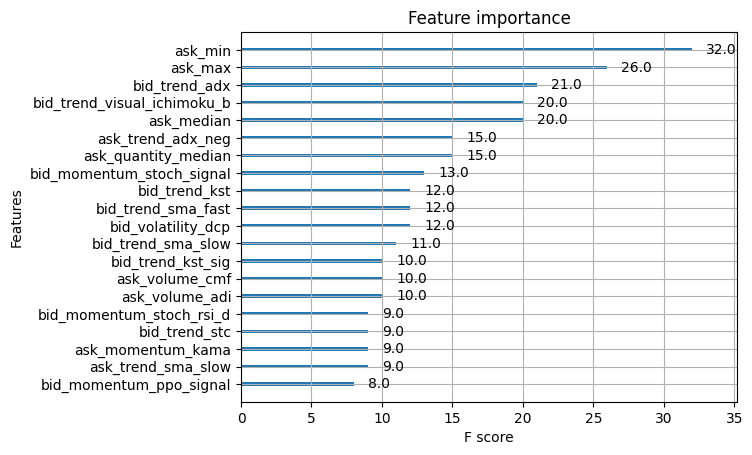

In [123]:
# plot feature importance
from xgboost import plot_importance
plot_importance(clf, max_num_features=20)

this means, that we can actually predict the price movement in the next 60s with accuracy, based on the features above!

In [124]:
pred = clf.predict(X)
scr = clf.score(X, Y)
print(scr)

0.9931372549019608


## simulated money market

In [152]:
import numpy as np 

pred = clf.predict(X)
print(np.unique(pred, return_counts=True))

def oneRun(TIMEUNTILEXECUTION=3, NRSIGSUNTILORDER=5):
    money = 10000
    eth = 0
    timeSinceOrder = 0
    order = None
    buyHoldEth = money / X["ask_min"][0]
    portfolio = []
    buyHoldPortfolio = []

    for i in range(NRSIGSUNTILORDER, len(X)):
        if order in ["buy", "sell"]:
            timeSinceOrder += 1
            if timeSinceOrder == TIMEUNTILEXECUTION:
                # execute order
                if order == "buy":
                    # print(i, "buying")
                    eth = money / X["ask_min"][i]
                    money = 0
                elif order == "sell":
                    # print(i, "selling")
                    money = eth * X["bid_max"][i]
                    eth = 0
                order = None
        else:
            if np.sum(pred[i-NRSIGSUNTILORDER:i]) == NRSIGSUNTILORDER and eth == 0 and money > 0:
                # trigger a buy, but it will need 3 time steps (30 sec)
                order = "buy"
                timeSinceOrder = 0
            elif np.sum(pred[i-NRSIGSUNTILORDER:i]) == 0 and eth > 0:
                # trigger a sell
                order = "sell"
                timeSinceOrder = 0
        portfolio.append(money + eth * X["bid_max"][i])
        buyHoldPortfolio.append(buyHoldEth * X["bid_max"][i])
    # last day sale
    if eth > 0:
        money = eth * X["bid_max"][i]
        eth = 0

    # print("money: ", money)
    # print("buyhold: ", buyHoldEth * X["bid_mean"][i])
    return portfolio[-1] - buyHoldPortfolio[-1], portfolio, buyHoldPortfolio

_ = oneRun()

(array([0, 1]), array([616, 404]))


In [158]:
# bruteforce
from tqdm import tqdm
best = -9999999
bestvals = None
for timeUntilExecution in tqdm(range(2, 50)): # eth execution can take 15s - 5 min, times two (sell, buy), so 2 - 120
   for i in range(1, 600):
      winoverhodl, portfolio, buyHoldPortfolio = oneRun(TIMEUNTILEXECUTION=timeUntilExecution, NRSIGSUNTILORDER=i)
      if winoverhodl > best:
         best = winoverhodl
         bestvals = (i, timeUntilExecution,  portfolio, buyHoldPortfolio)
print(best, bestvals[0], bestvals[1])

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [01:46<00:00,  2.23s/it]

68.51302692466925 15 2


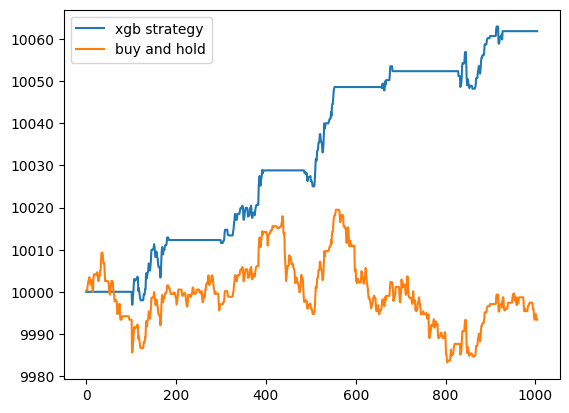

In [159]:
import matplotlib.pyplot as plt
plt.plot(bestvals[2], label = "xgb strategy")
plt.plot(bestvals[3], label = "buy and hold")
plt.legend()

In [160]:
timeFrame = df.index[-1] - df.index[0]
print(timeFrame)
win = bestvals[2][-1] - bestvals[3][0]
print("total win: ", win)
winPerHour = win / (timeFrame.total_seconds() / 3600)
winPerHourPct = winPerHour / bestvals[2][0]
print(winPerHour, winPerHourPct)
winPerMonthPct = winPerHourPct * 24 * 30
print("pct win per month: ", winPerMonthPct)

0 days 02:49:50
total win:  61.58347303104529
21.756673494775566 0.0021756673494775568
pct win per month:  1.5664804916238408
